# Import libraries

In [425]:
import os
mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-7.2.0-posix-seh-rt_v5-rev1\\mingw64\\bin'
os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
import datetime
import gc # Note: this is a garbage collector
%matplotlib inline

import warnings
warnings.filterwarnings('ignore') 

# Bring in data

In [426]:
PATH = r"..\Raw_Data"

In [427]:
data = {
    'airStore':  pd.read_csv(PATH + r"\air_store_info.csv"),
    'airVisit':  pd.read_csv(PATH + r"\air_visit_data.csv"),
    'date':      pd.read_csv(PATH + r"\date_info.csv"),
    'sampleSub': pd.read_csv(PATH + r"\sample_submission.csv"),
    'storeIDs':  pd.read_csv(PATH + r"\store_id_relation.csv")    
}

# Preprocess data

In [428]:
data['airVisit']['visit_date'].max()

'2017-04-22'

In [429]:
data['date']['visit_date'] = pd.to_datetime(data['date']['calendar_date'])
data['date'].drop('calendar_date', axis = 1 , inplace=True)

In [430]:
data['airVisit']['visit_date'] = pd.to_datetime(data['airVisit']['visit_date'])
data['airVisit']['dow'] = data['airVisit']['visit_date'].dt.dayofweek
data['airVisit']['year'] = data['airVisit']['visit_date'].dt.year
data['airVisit']['month'] = data['airVisit']['visit_date'].dt.month

## Add EWMA of visits as feature

Function to calculate ewm (note, found this on the competition discussion forum):

In [431]:
def calc_shifted_ewm(series, alpha, adjust = True):
    return series.shift().ewm(alpha = alpha, adjust = adjust).mean()

In [432]:
# Step below adds the ewm by day of week. Right now I'm returning a separate series so I can look at what each step does if I want to
tmp = data['airVisit'].groupby(['air_store_id','dow']).apply(lambda x: calc_shifted_ewm(x['visitors'], 0.1)) 
# This step backfills the 1st week's dow for each restaurant, otherwise it would be NaN since it's a 1-period ewma
#tmp = tmp.fillna(method='bfill')
# The groupby function returns a multiIndex Series. I only need the 3rd level (original df index) to add column to original df
tmp.index = tmp.index.get_level_values(2)
# Sort index before adding back to original df
tmp = tmp.sort_index()

In [433]:
data['airVisit']['ewma'] = tmp

## Add 'days since last' and 'days until next' holiday

In [434]:
# Create a 'days since holiday' feature
daysSinceList = []
daysSinceHol = 0 # initialize daysSince counter
for row in data['date']['holiday_flg']:
    if row == 1:
        daysSinceHol = 0
        daysSinceList.append(daysSinceHol)
    else:
        daysSinceHol += 1
        daysSinceList.append(daysSinceHol)
data['date']['days_since_holiday'] = daysSinceList

In [435]:
# Create a 'days UNTIL next holiday' feature
holidayList = list(data['date']['holiday_flg'])
daysUntilHolList = np.zeros(len(holidayList),dtype=np.int)
daysUntilHol = 0 # initialize daysUntilHol counter
for i in range(len(holidayList)-1,0,-1):
    if holidayList[i] == 1:
        daysUntilHol = 0
        daysUntilHolList[i] = daysUntilHol
    else:
        daysUntilHol += 1
        daysUntilHolList[i] = daysUntilHol        
data['date']['days_until_holiday'] = daysUntilHolList

## Merge air_visits with date dframe to get holiday info

In [436]:
colsToMerge = ['holiday_flg','visit_date','days_until_holiday','days_since_holiday']
df_train = pd.merge(data['airVisit'], data['date'][colsToMerge], how = 'left', on = 'visit_date')

## Filter only the stores that must be predicted

In [437]:
df_test = data['sampleSub']

df_test['visit_date'] = df_test['id'].map(lambda x: str(x).split('_')[2])
df_test['air_store_id'] = df_test['id'].map(lambda x: '_'.join(str(x).split('_')[:2]))
df_test['visit_date'] = pd.to_datetime(df_test['visit_date'])
df_test['dow'] = df_test['visit_date'].dt.dayofweek
df_test['year'] = df_test['visit_date'].dt.year
df_test['month'] = df_test['visit_date'].dt.month

unique_stores = df_test['air_store_id'].unique()
stores = pd.concat([pd.DataFrame({'air_store_id': unique_stores, 'dow': [i]*len(unique_stores)}) for i in range(7)], axis=0, ignore_index=True).reset_index(drop=True)
#stores.head()

## Merge df_test with date dframe to get holiday info

In [438]:
df_test = pd.merge(df_test, data['date'][colsToMerge], how = 'left', on = 'visit_date')

In [439]:
stores = pd.merge(stores, data['airStore'], how='left', on=['air_store_id'])
#stores.head()

In [440]:
# Encode categorical string variables 
lbl = LabelEncoder()
stores['air_genre_name'] = lbl.fit_transform(stores['air_genre_name'])
stores['air_area_name'] = lbl.fit_transform(stores['air_area_name'])

### Add genre and area to train and test data

In [441]:
df_train = pd.merge(df_train, stores, how = 'left', on = ['air_store_id','dow'])

### Add visitor statistics as features

In [442]:
tmp = df_train.groupby(['air_store_id','dow']).agg({'visitors' : [np.min,np.mean,np.median,np.max,np.size]}).reset_index()
tmp.columns = ['air_store_id', 'dow', 'min_visitors', 'mean_visitors', 'median_visitors','max_visitors','count_observations']
df_train = pd.merge(df_train, tmp, how='left', on=['air_store_id','dow'])

In [443]:
df_test = pd.merge(df_test, stores, how = 'left', on = ['air_store_id','dow'])

In [444]:
df_test = pd.merge(df_test, tmp, how='left', on=['air_store_id','dow'])

Note: For XGB, didn't fillna (1/28/2018)
Other algorithms need fillna. TODO: 1) investigate why there are NaN on train set. 2) Check if XGBoost gets better score with fillna

In [445]:
#df_train = df_train.fillna(-1)
#df_test = df_test.fillna(-1)

In [446]:
train = df_train
test = df_test
col = [c for c in train if c not in ['id', 'air_store_id','visit_date','visitors']]

# Initialize XGBoost
Note - code based on:
https://www.kaggle.com/jmbull/no-xgb-starter-here-s-one-lb-507

In [447]:
# XGB starter template borrowed from @anokas
# https://www.kaggle.com/anokas/simple-xgboost-starter-0-0655

print('Binding to float32')

for c, dtype in zip(df_train.columns, train.dtypes):
    if dtype == np.float64:
        train[c] = train[c].astype(np.float32)
        
for c, dtype in zip(df_test.columns, test.dtypes):
    if dtype == np.float64:
        test[c] = test[c].astype(np.float32)

Binding to float32


### Use cell below for validation using same weeks as test set but in the 2016 year

In [336]:
# Create training / validation split based on weeks in test set
x_train_setup = train.set_index('visit_date')

x_valid = x_train_setup['2016-04-23':'2016-05-31'].reset_index()
x_train = pd.concat([x_train_setup['2016-01-01':'2016-04-22'],
                     x_train_setup['2016-05-01':'2017-04-22']]).reset_index()

# Note: taking the absolute values makes the training take a VERY long time. I will instead take the log values
#y_train = x_train['visitors']
#y_valid = x_valid['visitors']

y_train = np.log1p(x_train['visitors'].values)
y_valid = np.log1p(x_valid['visitors'].values)

x_train = x_train.drop(['air_store_id','visit_date','visitors'], axis=1)
x_valid = x_valid.drop(['air_store_id','visit_date','visitors'], axis=1)

# Get Column order for x_test df
colOrder = x_train.columns

In [424]:
print(x_valid.shape)
print(x_train.shape)

(10336, 16)
(249933, 16)


### Use cell below for validation using split based on last rows in train dataframe

In [448]:
x_train = train.drop(['air_store_id','visit_date','visitors'], axis=1)
y_train = np.log1p(train['visitors'].values)

# Get Column order for x_test df
colOrder = x_train.columns

In [449]:
# Create training / validation split
split = 180000
x_train, y_train, x_valid, y_valid = x_train[:split], y_train[:split], x_train[split:], y_train[split:]

print('Building DMatrix...')

Building DMatrix...


In [450]:
d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)

#del x_train, x_valid; gc.collect()

In [453]:
print('Training ...')

params = {}
params['objective'] = 'reg:linear'
params['eval_metric'] = 'rmse'
params['eta'] = 0.04
params['max_depth'] = 7
params['silent'] = 1

watchlist = [(d_train, 'train'), (d_valid, 'valid')]
clf = xgb.train(params, d_train, 10000, watchlist, early_stopping_rounds=20, verbose_eval=20)

#del d_train, d_valid

Training ...
[0]	train-rmse:2.37129	valid-rmse:2.28627
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[20]	train-rmse:1.14611	valid-rmse:1.10928
[40]	train-rmse:0.682884	valid-rmse:0.665585
[60]	train-rmse:0.544978	valid-rmse:0.534895
[80]	train-rmse:0.510722	valid-rmse:0.503796
[100]	train-rmse:0.501159	valid-rmse:0.49639
[120]	train-rmse:0.497159	valid-rmse:0.494217
[140]	train-rmse:0.494411	valid-rmse:0.493462
[160]	train-rmse:0.492166	valid-rmse:0.493016
[180]	train-rmse:0.490079	valid-rmse:0.49271
[200]	train-rmse:0.488704	valid-rmse:0.492649
[220]	train-rmse:0.487392	valid-rmse:0.492655
[240]	train-rmse:0.48608	valid-rmse:0.492634
Stopping. Best iteration:
[194]	train-rmse:0.489022	valid-rmse:0.492622



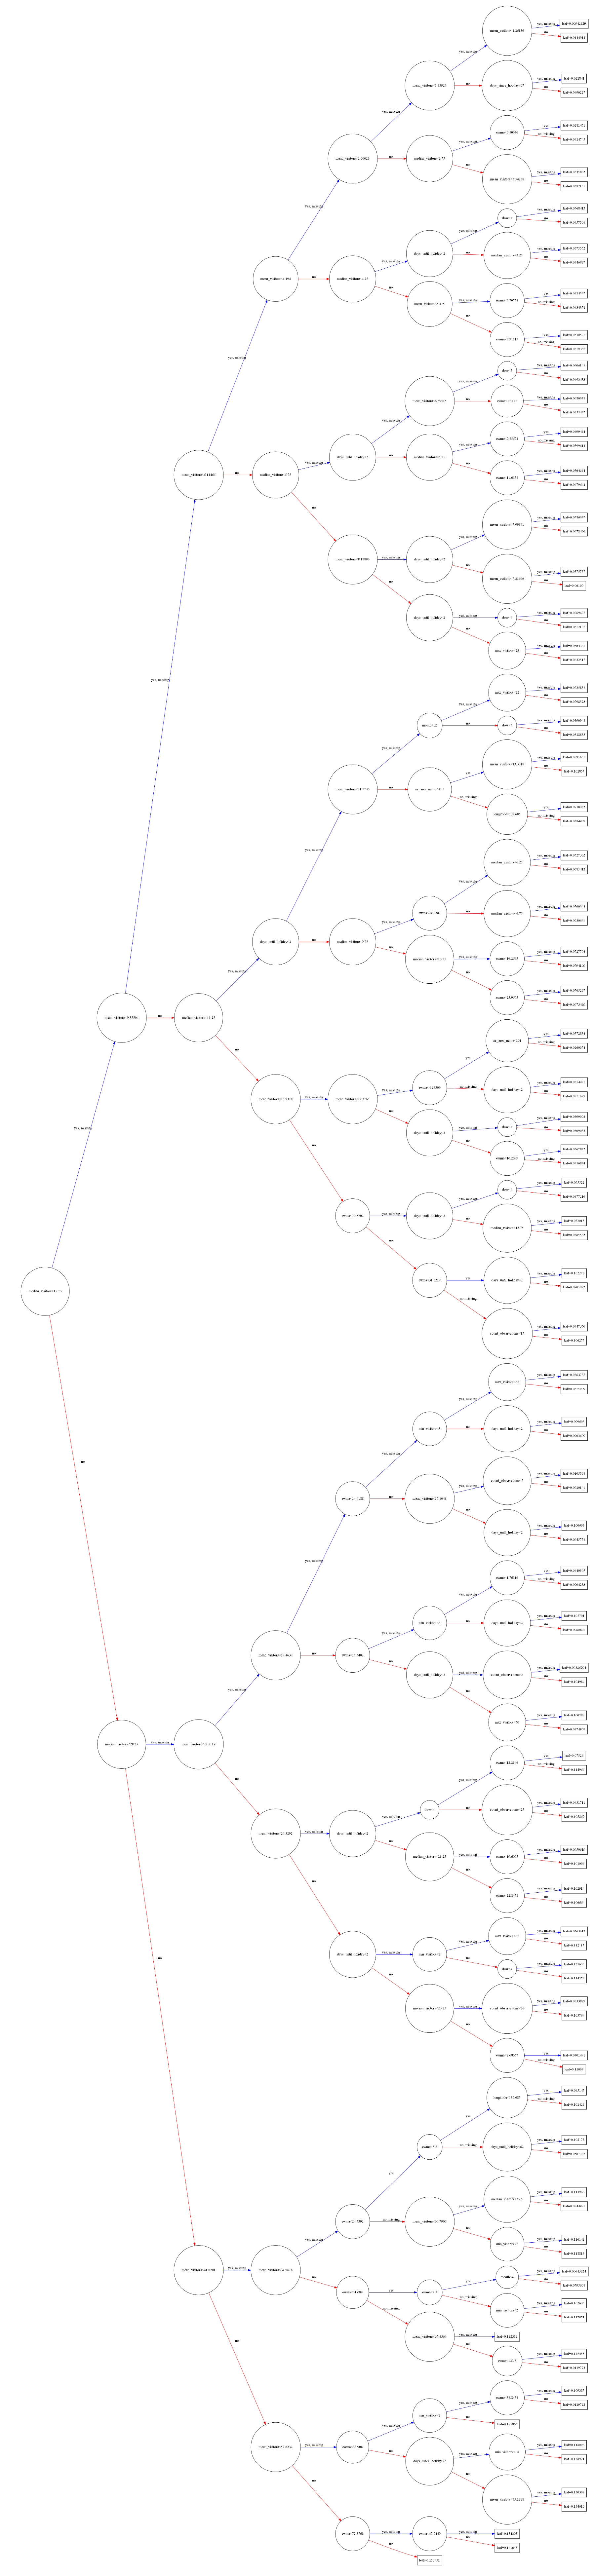

In [339]:
#print(clf.feature_names)
xgb.plot_tree(clf, num_trees=0,rankdir='LR')
fig = plt.gcf()
fig.set_size_inches(150, 100)
fig.savefig('tree.png')

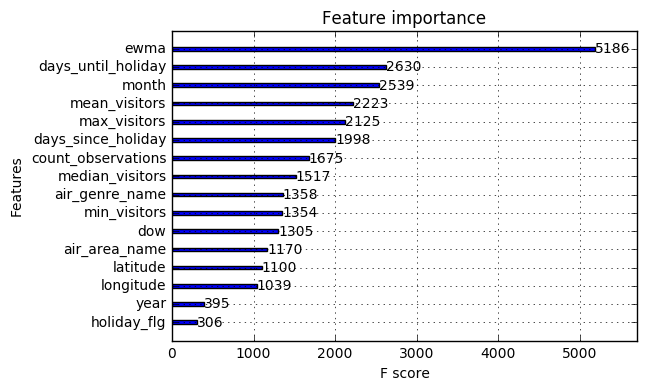

In [454]:
xgb.plot_importance(clf)

# Save the XBoost trained model

In [213]:
import pickle

In [214]:
pickle.dump(clf, open("recruit_rest_xgb_2016val.pickle.dat","wb"))

NOTE: To later retrieve the trained model, use command below: 

taken from:
https://machinelearningmastery.com/save-gradient-boosting-models-xgboost-python/

In [215]:
load_model = pickle.load(open("recruit_rest_xgb.pickle.dat","rb"))

## Use ewma feature in test set

Use dates from 2016

In [455]:
# Get dataframe for last week of training set and only use store
train_get_EWMA = train[['air_store_id','visit_date','dow','ewma']]
train_get_EWMA['id'] = train_get_EWMA['air_store_id'] + '_' + train_get_EWMA['visit_date'].astype(str)
train_get_EWMA.index = train_get_EWMA['visit_date']
train_get_EWMA = train_get_EWMA['2016-04-24':'2016-06-01']
train_get_EWMA = train_get_EWMA.drop(['visit_date'],axis=1).reset_index()
train_get_EWMA['id_last_year'] = train_get_EWMA['id']
train_get_EWMA.head()

visit_date          air_store_id  dow       ewma  \
0 2016-04-25  air_ba937bf13d40fb24    0  14.213490   
1 2016-04-26  air_ba937bf13d40fb24    1  18.060337   
2 2016-04-27  air_ba937bf13d40fb24    2  24.885893   
3 2016-04-28  air_ba937bf13d40fb24    3  21.879454   
4 2016-04-30  air_ba937bf13d40fb24    5  23.968468   

                                id                     id_last_year  
0  air_ba937bf13d40fb24_2016-04-25  air_ba937bf13d40fb24_2016-04-25  
1  air_ba937bf13d40fb24_2016-04-26  air_ba937bf13d40fb24_2016-04-26  
2  air_ba937bf13d40fb24_2016-04-27  air_ba937bf13d40fb24_2016-04-27  
3  air_ba937bf13d40fb24_2016-04-28  air_ba937bf13d40fb24_2016-04-28  
4  air_ba937bf13d40fb24_2016-04-30  air_ba937bf13d40fb24_2016-04-30

In [456]:
test_chk = test
#test_chk['date_to_subtract'] = pd.to_timedelta(364 , unit='d')
test_chk['date_last_year'] = pd.DatetimeIndex(test_chk['visit_date']) - pd.DateOffset(364)
test_chk['id_last_year'] = test_chk['air_store_id'] + '_' + test_chk['date_last_year'].astype(str)
test_chk.head()

id  visitors visit_date          air_store_id  \
0  air_00a91d42b08b08d9_2017-04-23         0 2017-04-23  air_00a91d42b08b08d9   
1  air_00a91d42b08b08d9_2017-04-24         0 2017-04-24  air_00a91d42b08b08d9   
2  air_00a91d42b08b08d9_2017-04-25         0 2017-04-25  air_00a91d42b08b08d9   
3  air_00a91d42b08b08d9_2017-04-26         0 2017-04-26  air_00a91d42b08b08d9   
4  air_00a91d42b08b08d9_2017-04-27         0 2017-04-27  air_00a91d42b08b08d9   

   dow  year  month  holiday_flg  days_until_holiday  days_since_holiday  \
0    6  2017      4            0                   6                  34   
1    0  2017      4            0                   5                  35   
2    1  2017      4            0                   4                  36   
3    2  2017      4            0                   3                  37   
4    3  2017      4            0                   2                  38   

                ...                 air_area_name   latitude   longitude  \
0               ...                            44  35.694004  139.753601   
1               ...                            44  35.694004  139.753601   
2               ...                            44  35.694004  139.753601   
3               ...                            44  35.694004  139.753601   
4               ...                            44  35.694004  139.753601   

   min_visitors  mean_visitors  median_visitors  max_visitors  \
0           2.0       2.000000              2.0           2.0   
1           1.0      22.457144             19.0          47.0   
2           1.0      24.350000             24.5          43.0   
3          15.0      28.125000             28.0          52.0   
4          15.0      29.868422             30.0          47.0   

   count_observations  date_last_year                     id_last_year  
0                 1.0      2016-04-24  air_00a91d42b08b08d9_2016-04-24  
1                35.0      2016-04-25  air_00a91d42b08b08d9_2016-04-25  
2                40.0      2016-04-26  air_00a91d42b08b08d9_2016-04-26  
3                40.0      2016-04-27  air_00a91d42b08b08d9_2016-04-27  
4                38.0      2016-04-28  air_00a91d42b08b08d9_2016-04-28  

[5 rows x 21 columns]

In [457]:
test_new = pd.merge(test_chk, train_get_EWMA[['id_last_year','ewma']], how = 'left', on = 'id_last_year')

In [458]:
#print(test_new['ewma'].isnull().sum())
#print(test_new.shape)
#print(train_get_EWMA['id_last_year'].loc[train_get_EWMA['id'] == 'air_00a91d42b08b08d9'])
#print(test_chk['air_store_id'].loc[test_chk['air_store_id'] == 'air_ba937bf13d40fb24'])
test_new = test_new.rename(columns={'ewma':'ewma_2016'})

In [459]:
test_new.index = test_new['visit_date']

test_new_Wk1 = test_new['2017-04-23':'2017-04-29']
test_new_Wk2 = test_new['2017-04-30':'2017-05-06']
test_new_Wk3 = test_new['2017-05-07':'2017-05-13']
test_new_Wk4 = test_new['2017-05-14':'2017-05-20']
test_new_Wk5 = test_new['2017-05-21':'2017-05-27']
test_new_Wk6 = test_new['2017-05-28':'2017-06-01']

In [460]:
#test_new_Wk1.head()

In [461]:
# Get dataframe for last week of training set and only use store
x_train_lastWk = train[['air_store_id','visit_date','dow','ewma']]
x_train_lastWk = x_train_lastWk[x_train_lastWk['visit_date'] > '2017-04-15']

In [462]:
# Split test by weeks [note that weeks start on day 6 (Sunday) rather than day 0 (Monday)]
test.index = test['visit_date']

testWk1 = test['2017-04-23':'2017-04-29']
testWk2 = test['2017-04-30':'2017-05-06']
testWk3 = test['2017-05-07':'2017-05-13']
testWk4 = test['2017-05-14':'2017-05-20']
testWk5 = test['2017-05-21':'2017-05-27']
testWk6 = test['2017-05-28':'2017-06-01']

In [463]:
testWk1_pred = pd.merge(testWk1, x_train_lastWk.drop('visit_date',axis=1),how='left',on=['air_store_id','dow'])

In [464]:
testWk1_pred = pd.merge(testWk1_pred, test_new_Wk1[['id','ewma_2016']], how = 'left', on='id')

In [465]:
#testWk1_pred['ewma'] = testWk1_pred['ewma'].fillna(value=0)

In [466]:
#testWk1_pred.head(15)

In [467]:
testWk1_pred['ewma_compile'] = np.where(testWk1_pred['ewma_2016'].isnull(), testWk1_pred['ewma'],testWk1_pred['ewma_2016'])

In [468]:
#testWk1_pred.head(15)

In [469]:
testWk1_pred = testWk1_pred.drop(['ewma','ewma_2016'], axis=1)

In [470]:
testWk1_pred = testWk1_pred.rename(columns={'ewma_compile':'ewma'})
#testWk1_pred.head 

Command to put columns in the right order for the XGBoost prediction

In [471]:
# NOTE: USE COLUMN LIST BELOW IF NOT INCLUDING VISITOR STATISTICS IN TRAINING SET

#columnsForTest_df = ['dow', 'year', 'month', 'ewma', 'holiday_flg', 'days_until_holiday',
#       'days_since_holiday', 'air_genre_name', 'air_area_name', 'latitude',
#       'longitude']

# NOTE: USE COLUMN LIST BELOW IF INCLUDING VISITOR STATISTICS IN TRAINING SET
columnsForTest_df = ['dow', 'year', 'month', 'ewma', 'holiday_flg', 'days_until_holiday', 'days_since_holiday',
                     'air_genre_name', 'air_area_name', 'latitude', 'longitude', 'min_visitors', 'mean_visitors',
                     'median_visitors', 'max_visitors', 'count_observations']

In [472]:
x_testWk1_pred = testWk1_pred.drop(['id','air_store_id','visit_date','visitors'],axis=1)
x_testWk1_pred = x_testWk1_pred[columnsForTest_df]

In [473]:
d_test = xgb.DMatrix(x_testWk1_pred)
#del x_test; gc.collect()

In [474]:
print('Predicting on test ...')
p_test = clf.predict(d_test)
del d_test; gc.collect()

Predicting on test ...


300

In [475]:
testWk1_pred['visitors'] = np.expm1(p_test)
testWk1_pred[['id','visitors']].to_csv('xgb_submission_Wk1.csv', index=False, float_format='%.3f')

### With test set Week 1 predicted, update ewma and assign to week 2

In [476]:
train_testWk1_concat = testWk1_pred[train.columns]
train_testWk1_concat = pd.concat([train, train_testWk1_concat])
train_testWk1_concat = train_testWk1_concat.reset_index()
tmp = train_testWk1_concat.groupby(['air_store_id','dow']).apply(lambda x: calc_shifted_ewm(x['visitors'],0.1))
tmp = tmp.fillna(method='bfill')
tmp.index = tmp.index.get_level_values(2)
tmp = tmp.sort_index()

In [477]:
train_testWk1_concat['ewma'] = tmp

In [478]:
tmp = train_testWk1_concat[train_testWk1_concat['visit_date'] > testWk2.visit_date.min() - pd.to_timedelta(1, unit='d')]
tmp = tmp[['air_store_id','visit_date','dow','ewma']]
testWk2_pred = pd.merge(testWk2, tmp.drop('visit_date',axis=1),how='left',on=['air_store_id','dow'])
#testWk2_pred['ewma'] = testWk2_pred['ewma'].fillna(value=0)

In [479]:
testWk2_pred = pd.merge(testWk2_pred, test_new_Wk2[['id','ewma_2016']], how = 'left', on='id')

In [480]:
testWk2_pred['ewma_compile'] = np.where(testWk2_pred['ewma_2016'].isnull(), testWk2_pred['ewma'],testWk2_pred['ewma_2016'])
testWk2_pred = testWk2_pred.drop(['ewma','ewma_2016'], axis=1)
testWk2_pred = testWk2_pred.rename(columns={'ewma_compile':'ewma'})

In [481]:
x_testWk2_pred = testWk2_pred.drop(['id','air_store_id','visit_date','visitors'],axis=1)
x_testWk2_pred = x_testWk2_pred[columnsForTest_df]
#x_testWk2_pred.columns

In [482]:
d_test = xgb.DMatrix(x_testWk2_pred)
#del x_test; gc.collect()

In [483]:
print('Predictin on test ...')
p_test = clf.predict(d_test)
del d_test; gc.collect()

Predictin on test ...


182

In [484]:
testWk2_pred['visitors'] = np.expm1(p_test)
testWk2_pred[['id','visitors']].to_csv('xgb_submission_Wk2.csv',index=False,float_format='%.3f')

### With test set Week 2 predicted, update ewma and assign to week 3

In [485]:
train_testWk2_concat = testWk2_pred[train.columns]
train_testWk2_concat = pd.concat([train_testWk1_concat, train_testWk2_concat])
train_testWk2_concat = train_testWk2_concat.reset_index()
tmp = train_testWk2_concat.groupby(['air_store_id','dow']).apply(lambda x: calc_shifted_ewm(x['visitors'],0.1))
tmp = tmp.fillna(method='bfill')
tmp.index = tmp.index.get_level_values(2)
tmp = tmp.sort_index()

In [486]:
train_testWk2_concat['ewma'] = tmp

In [487]:
tmp = train_testWk2_concat[train_testWk2_concat['visit_date'] > testWk3.visit_date.min() - pd.to_timedelta(1, unit='d')]
tmp = tmp[['air_store_id','visit_date','dow','ewma']]
testWk3_pred = pd.merge(testWk3, tmp.drop('visit_date',axis=1),how='left',on=['air_store_id','dow'])
#testWk3_pred['ewma'] = testWk3_pred['ewma'].fillna(value=0)

In [488]:
testWk3_pred = pd.merge(testWk3_pred, test_new_Wk3[['id','ewma_2016']], how = 'left', on='id')

In [489]:
testWk3_pred['ewma_compile'] = np.where(testWk3_pred['ewma_2016'].isnull(), testWk3_pred['ewma'],testWk3_pred['ewma_2016'])
testWk3_pred = testWk3_pred.drop(['ewma','ewma_2016'], axis=1)
testWk3_pred = testWk3_pred.rename(columns={'ewma_compile':'ewma'})

In [490]:
x_testWk3_pred = testWk3_pred.drop(['id','air_store_id','visit_date','visitors'],axis=1)
x_testWk3_pred = x_testWk3_pred[columnsForTest_df]

In [491]:
d_test = xgb.DMatrix(x_testWk3_pred)
#del x_test; gc.collect()

In [492]:
print('Predictin on test ...')
p_test = clf.predict(d_test)
del d_test; gc.collect()

Predictin on test ...


216

In [493]:
testWk3_pred['visitors'] = np.expm1(p_test)
testWk3_pred[['id','visitors']].to_csv('xgb_submission_Wk3.csv',index=False,float_format='%.3f')

### With test set Week 3 predicted, update ewma and assign to week 4

In [494]:
train_testWk3_concat = pd.concat([train_testWk2_concat[train.columns], testWk3_pred[train.columns]])
train_testWk3_concat = train_testWk3_concat.reset_index()
tmp = train_testWk3_concat.groupby(['air_store_id','dow']).apply(lambda x: calc_shifted_ewm(x['visitors'],0.1))
tmp = tmp.fillna(method='bfill')
tmp.index = tmp.index.get_level_values(2)
tmp = tmp.sort_index()

In [495]:
train_testWk3_concat['ewma'] = tmp

In [496]:
tmp = train_testWk3_concat[train_testWk3_concat['visit_date'] > testWk4.visit_date.min() - pd.to_timedelta(1, unit='d')]
tmp = tmp[['air_store_id','visit_date','dow','ewma']]
testWk4_pred = pd.merge(testWk4, tmp.drop('visit_date',axis=1),how='left',on=['air_store_id','dow'])
#testWk4_pred['ewma'] = testWk4_pred['ewma'].fillna(value=0)

In [497]:
testWk4_pred = pd.merge(testWk4_pred, test_new_Wk4[['id','ewma_2016']], how = 'left', on='id')
testWk4_pred['ewma_compile'] = np.where(testWk4_pred['ewma_2016'].isnull(), testWk4_pred['ewma'],testWk4_pred['ewma_2016'])
testWk4_pred = testWk4_pred.drop(['ewma','ewma_2016'], axis=1)
testWk4_pred = testWk4_pred.rename(columns={'ewma_compile':'ewma'})

In [498]:
x_testWk4_pred = testWk4_pred.drop(['id','air_store_id','visit_date','visitors'],axis=1)
x_testWk4_pred = x_testWk4_pred[columnsForTest_df]

In [499]:
d_test = xgb.DMatrix(x_testWk4_pred)
#del x_test; gc.collect()

In [500]:
print('Predictin on test ...')
p_test = clf.predict(d_test)
del d_test; gc.collect()

Predictin on test ...


216

In [501]:
testWk4_pred['visitors'] = np.expm1(p_test)
testWk4_pred[['id','visitors']].to_csv('xgb_submission_Wk4.csv',index=False,float_format='%.3f')

### With test set Week 4 predicted, update ewma and assign to week 5

In [502]:
train_testWk4_concat = pd.concat([train_testWk3_concat[train.columns], testWk4_pred[train.columns]])
train_testWk4_concat = train_testWk4_concat.reset_index()
tmp = train_testWk4_concat.groupby(['air_store_id','dow']).apply(lambda x: calc_shifted_ewm(x['visitors'],0.1))
tmp = tmp.fillna(method='bfill')
tmp.index = tmp.index.get_level_values(2)
tmp = tmp.sort_index()

In [503]:
train_testWk4_concat['ewma'] = tmp

In [504]:
tmp = train_testWk4_concat[train_testWk4_concat['visit_date'] > testWk5.visit_date.min() - pd.to_timedelta(1, unit='d')]
tmp = tmp[['air_store_id','visit_date','dow','ewma']]
testWk5_pred = pd.merge(testWk5, tmp.drop('visit_date',axis=1),how='left',on=['air_store_id','dow'])
#testWk5_pred['ewma'] = testWk5_pred['ewma'].fillna(value=0)

In [505]:
testWk5_pred = pd.merge(testWk5_pred, test_new_Wk5[['id','ewma_2016']], how = 'left', on='id')
testWk5_pred['ewma_compile'] = np.where(testWk5_pred['ewma_2016'].isnull(), testWk5_pred['ewma'],testWk5_pred['ewma_2016'])
testWk5_pred = testWk5_pred.drop(['ewma','ewma_2016'], axis=1)
testWk5_pred = testWk5_pred.rename(columns={'ewma_compile':'ewma'})

In [506]:
x_testWk5_pred = testWk5_pred.drop(['id','air_store_id','visit_date','visitors'],axis=1)
x_testWk5_pred = x_testWk5_pred[columnsForTest_df]

In [507]:
d_test = xgb.DMatrix(x_testWk5_pred)
#del x_test; gc.collect()

In [508]:
print('Predictin on test ...')
p_test = clf.predict(d_test)
del d_test; gc.collect()

Predictin on test ...


216

In [509]:
testWk5_pred['visitors'] = np.expm1(p_test)
testWk5_pred[['id','visitors']].to_csv('xgb_submission_Wk5.csv',index=False,float_format='%.3f')

### With test set Week 5 predicted, update ewma and assign to week 6

In [510]:
train_testWk5_concat = pd.concat([train_testWk4_concat[train.columns], testWk5_pred[train.columns]])
train_testWk5_concat = train_testWk5_concat.reset_index()
tmp = train_testWk5_concat.groupby(['air_store_id','dow']).apply(lambda x: calc_shifted_ewm(x['visitors'],0.1))
tmp = tmp.fillna(method='bfill')
tmp.index = tmp.index.get_level_values(2)
tmp = tmp.sort_index()

In [511]:
train_testWk5_concat['ewma'] = tmp

In [512]:
tmp = train_testWk5_concat[train_testWk5_concat['visit_date'] > testWk6.visit_date.min() - pd.to_timedelta(1, unit='d')]
tmp = tmp[['air_store_id','visit_date','dow','ewma']]
testWk6_pred = pd.merge(testWk6, tmp.drop('visit_date',axis=1),how='left',on=['air_store_id','dow'])
#testWk6_pred['ewma'] = testWk6_pred['ewma'].fillna(value=0)

In [513]:
testWk6_pred = pd.merge(testWk6_pred, test_new_Wk6[['id','ewma_2016']], how = 'left', on='id')
testWk6_pred['ewma_compile'] = np.where(testWk6_pred['ewma_2016'].isnull(), testWk6_pred['ewma'],testWk6_pred['ewma_2016'])
testWk6_pred = testWk6_pred.drop(['ewma','ewma_2016'], axis=1)
testWk6_pred = testWk6_pred.rename(columns={'ewma_compile':'ewma'})

In [514]:
x_testWk6_pred = testWk6_pred.drop(['id','air_store_id','visit_date','visitors'],axis=1)
x_testWk6_pred = x_testWk6_pred[columnsForTest_df]

In [515]:
d_test = xgb.DMatrix(x_testWk6_pred)
#del x_test; gc.collect()

In [516]:
print('Predictin on test ...')
p_test = clf.predict(d_test)
del d_test; gc.collect()

Predictin on test ...


179

In [517]:
testWk6_pred['visitors'] = np.expm1(p_test)
testWk6_pred[['id','visitors']].to_csv('xgb_submission_Wk6.csv',index=False,float_format='%.3f')

### Compile all prediction csv and sort in order needed for submission

In [518]:
pred_wk1 = pd.read_csv('xgb_submission_Wk1.csv')
pred_wk2 = pd.read_csv('xgb_submission_Wk2.csv')
pred_wk3 = pd.read_csv('xgb_submission_Wk3.csv')
pred_wk4 = pd.read_csv('xgb_submission_Wk4.csv')
pred_wk5 = pd.read_csv('xgb_submission_Wk5.csv')
pred_wk6 = pd.read_csv('xgb_submission_Wk6.csv')

In [519]:
compiled_predictions = pd.concat([pred_wk1,pred_wk2,pred_wk3,pred_wk4,pred_wk5,pred_wk6]).sort_values(by='id')

In [520]:
compiled_predictions[['id','visitors']].to_csv('xgb_submission-20180204.csv',index=False,float_format='%.3f')

# Now recompute all EWMA using the predictions

In [536]:
#test.head()
#train.head()

In [522]:
test_recalc = pd.merge(test.drop(['visitors'], axis=1), compiled_predictions, how = 'left', on= ['id'])
test_recalc.head()

id visit_date          air_store_id  dow  \
0  air_00a91d42b08b08d9_2017-04-23 2017-04-23  air_00a91d42b08b08d9    6   
1  air_00a91d42b08b08d9_2017-04-24 2017-04-24  air_00a91d42b08b08d9    0   
2  air_00a91d42b08b08d9_2017-04-25 2017-04-25  air_00a91d42b08b08d9    1   
3  air_00a91d42b08b08d9_2017-04-26 2017-04-26  air_00a91d42b08b08d9    2   
4  air_00a91d42b08b08d9_2017-04-27 2017-04-27  air_00a91d42b08b08d9    3   

   year  month  holiday_flg  days_until_holiday  days_since_holiday  \
0  2017      4            0                   6                  34   
1  2017      4            0                   5                  35   
2  2017      4            0                   4                  36   
3  2017      4            0                   3                  37   
4  2017      4            0                   2                  38   

   air_genre_name   ...      latitude   longitude  min_visitors  \
0               6   ...     35.694004  139.753601           2.0   
1               6   ...     35.694004  139.753601           1.0   
2               6   ...     35.694004  139.753601           1.0   
3               6   ...     35.694004  139.753601          15.0   
4               6   ...     35.694004  139.753601          15.0   

   mean_visitors  median_visitors  max_visitors  count_observations  \
0       2.000000              2.0           2.0                 1.0   
1      22.457144             19.0          47.0                35.0   
2      24.350000             24.5          43.0                40.0   
3      28.125000             28.0          52.0                40.0   
4      29.868422             30.0          47.0                38.0   

   date_last_year                     id_last_year visitors  
0      2016-04-24  air_00a91d42b08b08d9_2016-04-24    1.788  
1      2016-04-25  air_00a91d42b08b08d9_2016-04-25   19.250  
2      2016-04-26  air_00a91d42b08b08d9_2016-04-26   24.103  
3      2016-04-27  air_00a91d42b08b08d9_2016-04-27   28.808  
4      2016-04-28  air_00a91d42b08b08d9_2016-04-28   30.135  

[5 rows x 21 columns]

In [523]:
test_recalc = test_recalc.drop(['date_last_year', 'id_last_year'], axis=1)

In [524]:
train_recalc = train
train_recalc['id'] = train['air_store_id'] +'_'+ train['visit_date'].astype(str)
test_pred2 = pd.concat([train_recalc[test_recalc.columns], test_recalc])
test_pred2 = test_pred2.reset_index()

In [525]:
#test_pred2.visit_date.min()
test_pred2.head()

index                               id visit_date          air_store_id  \
0      0  air_ba937bf13d40fb24_2016-01-13 2016-01-13  air_ba937bf13d40fb24   
1      1  air_ba937bf13d40fb24_2016-01-14 2016-01-14  air_ba937bf13d40fb24   
2      2  air_ba937bf13d40fb24_2016-01-15 2016-01-15  air_ba937bf13d40fb24   
3      3  air_ba937bf13d40fb24_2016-01-16 2016-01-16  air_ba937bf13d40fb24   
4      4  air_ba937bf13d40fb24_2016-01-18 2016-01-18  air_ba937bf13d40fb24   

   dow  year  month  holiday_flg  days_until_holiday  days_since_holiday  \
0    2  2016      1            0                  29                   2   
1    3  2016      1            0                  28                   3   
2    4  2016      1            0                  27                   4   
3    5  2016      1            0                  26                   5   
4    0  2016      1            0                  24                   7   

   air_genre_name  air_area_name  latitude   longitude  min_visitors  \
0             4.0           62.0  35.65807  139.751602           7.0   
1             4.0           62.0  35.65807  139.751602           2.0   
2             4.0           62.0  35.65807  139.751602           4.0   
3             4.0           62.0  35.65807  139.751602           6.0   
4             4.0           62.0  35.65807  139.751602           2.0   

   mean_visitors  median_visitors  max_visitors  count_observations  visitors  
0      23.843750             25.0          57.0                64.0      25.0  
1      20.292307             21.0          54.0                65.0      32.0  
2      34.738461             35.0          61.0                65.0      29.0  
3      27.651516             27.0          53.0                66.0      22.0  
4      13.754386             12.0          34.0                57.0       6.0

### Now, recalc EWMA based on predictions from 1st pass

In [527]:
tmp = test_pred2.groupby(['air_store_id','dow']).apply(lambda x: calc_shifted_ewm(x['visitors'], 0.1))
tmp = tmp.fillna(method='bfill')
tmp.index = tmp.index.get_level_values(2)
tmp = tmp.sort_index()

In [528]:
tmp.head(10)

0    25.0
1    32.0
2    29.0
3    22.0
4     6.0
5     9.0
6    25.0
7    32.0
8    29.0
9    22.0
Name: visitors, dtype: float64

In [529]:
test_pred2['ewma'] = tmp
#test_pred2.head()

In [530]:
test_pred2 = test_pred2[test_pred2['visit_date'] > '2017-04-22']
id_sub_col = test_pred2['id']
test_pred2 = test_pred2[columnsForTest_df]

In [531]:
id_sub_col.head()

252108    air_00a91d42b08b08d9_2017-04-23
252109    air_00a91d42b08b08d9_2017-04-24
252110    air_00a91d42b08b08d9_2017-04-25
252111    air_00a91d42b08b08d9_2017-04-26
252112    air_00a91d42b08b08d9_2017-04-27
Name: id, dtype: object

In [532]:
test_pred2.head()

dow  year  month       ewma  holiday_flg  days_until_holiday  \
252108    6  2017      4   2.000000            0                   6   
252109    0  2017      4  25.481499            0                   5   
252110    1  2017      4  28.847168            0                   4   
252111    2  2017      4  29.447872            0                   3   
252112    3  2017      4  32.135752            0                   2   

        days_since_holiday  air_genre_name  air_area_name   latitude  \
252108                  34             6.0           44.0  35.694004   
252109                  35             6.0           44.0  35.694004   
252110                  36             6.0           44.0  35.694004   
252111                  37             6.0           44.0  35.694004   
252112                  38             6.0           44.0  35.694004   

         longitude  min_visitors  mean_visitors  median_visitors  \
252108  139.753601           2.0       2.000000              2.0   
252109  139.753601           1.0      22.457144             19.0   
252110  139.753601           1.0      24.350000             24.5   
252111  139.753601          15.0      28.125000             28.0   
252112  139.753601          15.0      29.868422             30.0   

        max_visitors  count_observations  
252108           2.0                 1.0  
252109          47.0                35.0  
252110          43.0                40.0  
252111          52.0                40.0  
252112          47.0                38.0

In [533]:
d_test = xgb.DMatrix(test_pred2)

In [534]:
p_test = clf.predict(d_test)

In [ ]:
test_pred2['visitors'] = np.expm1(p_test)
test_pred2['id'] = id_sub_col
test_pred2[['id','visitors']].to_csv('xgb_sub_recalc_EWMA_2016val.csv',index=False,float_format='%.3f')

### 2nd recompute just for fun?

In [537]:
test_recalc2 = pd.merge(test.drop(['visitors'],axis=1),test_pred2[['id','visitors']],how='left',on='id')

In [544]:
test_recalc2 = test_recalc2.drop(['date_last_year','id_last_year'],axis=1)

In [545]:
test_pred3 = pd.concat([train_recalc[test_recalc2.columns],test_recalc2])
test_pred3 = test_pred3.reset_index()

In [546]:
tmp = test_pred3.groupby(['air_store_id','dow']).apply(lambda x: calc_shifted_ewm(x['visitors'], 0.1))
tmp = tmp.fillna(method='bfill')
tmp.index = tmp.index.get_level_values(2)
tmp = tmp.sort_index()

In [547]:
test_pred3['ewma']=tmp

In [548]:
test_pred3 = test_pred3[test_pred3['visit_date'] > '2017-04-22']
id_sub_col = test_pred3['id']
test_pred3 = test_pred3[columnsForTest_df]

In [550]:
d_test = xgb.DMatrix(test_pred3)

In [551]:
p_test = clf.predict(d_test)

In [552]:
test_pred3['visitors'] = np.expm1(p_test)
test_pred3['id'] = id_sub_col
test_pred3[['id','visitors']].to_csv('xgb_sub_recalc_EWMA_2016val_lastSub.csv',index=False,float_format='%.3f')